# ***Living Coasts*** Information and Training <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.sandbox.dea.ga.gov.au/ga_ls_landcover_class_cyear_2)


## Selection of an area of interest using an interactive map

Through Geoscience Australia's (GA) Digital Earth Australia (DEA) Land Cover, land cover maps have been generated for 34 years (1988 to 2020) from environmental descriptors retrieved or classified entirely from Landsat sensor data and according to the Food and Agriculture Organisation (FAO) Land Cover Classification System (Version 2).  The spatial resolution of the mapping is 25 m 
(see DEA Land Cover) at https://cmi.ga.gov.au/data-products/dea/607/dea-land-cover-landsat)

This notebooks allows you to use an interactive map to load up an area of land cover and other environmental descriptors for a selected time-period.  

## Description 

The notebook will demonstrate how you can interrogate and interactive map to load up an area of the Digital Earth Australia (DEA) land cover map and environmental descriptors used in their construction and description.   

The notebooks take you through the process of:

1. Identifying an area interactively using a rectangle or polygon drawn freehand. 
2. Displaying the Level 3 land cover maps and environmental descriptors of lifeform, canopy cover, water persistence and water seasonality.  

If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

### Setting up


In [1]:
# Initial imports and setup
import sys
import os, re
import datacube
import datetime as dt
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors
import matplotlib as mpl
import cmocean # for intertidal products
import odc.geo.xr # RML
import pandas as pd
import rioxarray
import warnings
import xarray as xr

#from dea_tools.landcover import lc_colourmap, make_colorbar, plot_land_cover
from dea_tools.plotting import display_map, rgb, xr_animation # Added xr_animation RML

from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import Geometry
from datetime import datetime, timedelta
from ipyleaflet import DrawControl, FullScreenControl, LayersControl, Map, Rectangle, WidgetControl, basemaps # Added rectangle RML
from ipywidgets import Button, Dropdown, FloatText, GridspecLayout, Layout, HBox, VBox, Output, Tab, interact, widgets
from IPython.display import HTML, display
from IPython.core.display import Video
from pyproj import Proj, transform
from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing
from time import time
warnings.filterwarnings("ignore")

# Setup paths and Datacube instance
#import sys
#sys.path.insert(1, "/home/Tools")

dc = datacube.Datacube()
time_range = None

sys.path.append("../Working")
import display_tools
from display_tools import display_da
from landcover import lc_colourmap, make_colorbar, plot_land_cover

# Ensure openpyxl is installed
!pip install openpyxl


### Select your area of interest

In [2]:
# Initialize global variables to store the selected polygon
selected_polygon = None
manual_polygon_layer = None

# Define lat_range and lon_range to avoid NameError in Section 5
lat_range = None
lon_range = None

# Create the map
m = Map(center=[0, 0], zoom=2, basemap=basemaps.Esri.WorldImagery, scroll_wheel_zoom=True, layout=Layout(height='600px'))
m.add_control(LayersControl(position='topright'))
m.add_control(FullScreenControl())

# Output widget to display coordinates
output = Output(layout={'border': '1px solid black', 'padding': '5px'})

# Setup the draw control with both polygon and rectangle options
draw_control = DrawControl(
    rectangle={"shapeOptions": {"color": "#0000FF"}},
    polygon={"shapeOptions": {"color": "#00FF00"}},
    circlemarker={},
    polyline={},
    circle={}
)
m.add_control(draw_control)

# Event handler for drawing shapes
def handle_draw(target, action, geo_json):
    global selected_polygon, lat_range, lon_range
    output.clear_output()
    coords = geo_json['geometry']['coordinates'][0]
    selected_polygon = Polygon(coords)
    # Ensure consistent ordering of coordinates (assuming lon-lat order)
    lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
    lat_range = (min(lats), max(lats))
    lon_range = (min(lons), max(lons))
    with output:
        output.append_stdout("Coordinates:\n")
        output.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
        for lat, lon in zip(lats, lons):
            output.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")

draw_control.on_draw(handle_draw)

# Button to clear drawings and output
clear_button_draw = Button(description='Clear All')
clear_button_manual = Button(description='Clear All')

# Event handler for the clear button
def clear_all(b):
    global selected_polygon, manual_polygon_layer, lat_range, lon_range
    draw_control.clear()
    output.clear_output()
    if manual_polygon_layer:
        m.remove_layer(manual_polygon_layer)
    selected_polygon = None
    manual_polygon_layer = None
    lat_range = None
    lon_range = None

clear_button_draw.on_click(clear_all)
clear_button_manual.on_click(clear_all)

# Create input widgets for manual coordinate entry
latitude = FloatText(description='Latitude:', layout=Layout(width='100%'))
longitude = FloatText(description='Longitude:', layout=Layout(width='100%'))
buffer = FloatText(description='Buffer (deg):', value=0.1, layout=Layout(width='100%'))
update_button = Button(description='Update Map')

# Function to update the map based on manual input values
def update_map_manual(b):
    global manual_polygon_layer, selected_polygon, lat_range, lon_range
    output.clear_output()
    lat = latitude.value
    lon = longitude.value
    buf = buffer.value
    
    if lat is not None and lon is not None and buf is not None:
        bounds = [[lat - buf, lon - buf], [lat + buf, lon + buf]]
        if manual_polygon_layer:
            m.remove_layer(manual_polygon_layer)
        manual_polygon_layer = Rectangle(bounds=bounds, color="blue", fill_opacity=0.2, weight=2)
        m.add_layer(manual_polygon_layer)
        m.fit_bounds(bounds)
        
        selected_polygon = Polygon([(lon - buf, lat - buf), (lon + buf, lat - buf), (lon + buf, lat + buf), (lon - buf, lat + buf), (lon - buf, lat - buf)])
        lat_range = (lat - buf, lat + buf)
        lon_range = (lon - buf, lon + buf)
        
        with output:
            output.append_stdout("Manual Coordinates:\n")
            output.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            output.append_stdout(f"{lat - buf:.6f}\t\t{lon - buf:.6f}\n")
            output.append_stdout(f"{lat - buf:.6f}\t\t{lon + buf:.6f}\n")
            output.append_stdout(f"{lat + buf:.6f}\t\t{lon + buf:.6f}\n")
            output.append_stdout(f"{lat + buf:.6f}\t\t{lon - buf:.6f}\n")
    else:
        with output:
            output.append_stdout("Please fill in all coordinate values.\n")

# Connect the manual update button
update_button.on_click(update_map_manual)

# Tab widget for drawing and manual input
draw_tab = VBox([clear_button_draw, output])
manual_tab = VBox([latitude, longitude, buffer, update_button, clear_button_manual, output])

tab = Tab()
tab.children = [draw_tab, manual_tab]
tab.set_title(0, 'Draw')
tab.set_title(1, 'Manual Input')

# Add the tab control to the map
tab_control = WidgetControl(widget=tab, position='topright')
m.add_control(tab_control)

# Display the map
display(m)



Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

### Section 3: Confirm the area selected

The drawn shape was used for selection.
The geopolygon of interest is the following one; 
POLYGON ((153.007815 -24.891789, 153.007815 -24.679836, 153.348391 -24.679836, 153.348391 -24.891789, 153.007815 -24.891789))

Selected Polygon Coordinates:
Latitude: -24.891789, Longitude: 153.007815
Latitude: -24.679836, Longitude: 153.007815
Latitude: -24.679836, Longitude: 153.348391
Latitude: -24.891789, Longitude: 153.348391
Latitude: -24.891789, Longitude: 153.007815

UTM Coordinates:
UTM X: 4992461.967211031, UTM Y: -16452428.753425818
UTM X: 5002935.023512959, UTM Y: -16480091.123856638
UTM X: 4962329.478542498, UTM Y: -16495311.471899288
UTM X: 4952006.1262551015, UTM Y: -16467714.520473173
UTM X: 4992461.967211031, UTM Y: -16452428.753425818


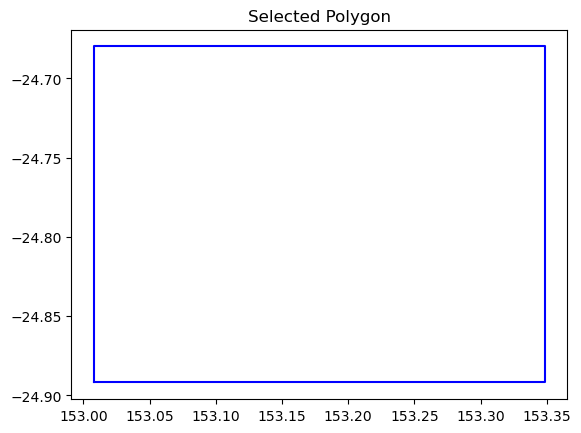

In [3]:
import matplotlib.pyplot as plt
from pyproj import Proj
from shapely.geometry.polygon import LinearRing

# Function to convert latitude and longitude to UTM coordinates
def latlon_to_utm(lat, lon):
    utm_proj = Proj(proj="utm", zone=33, datum="WGS84")  # Change zone as needed
    utm_x, utm_y = utm_proj(lon, lat)
    return utm_x, utm_y

# Function to display the selected coordinates, UTM coordinates, and visualize the polygon
def display_selected_coordinates(selected_polygon):
    if selected_polygon is not None:
        coords = selected_polygon.exterior.coords
        utm_coords = [latlon_to_utm(lat, lon) for lon, lat in coords]

        print("The drawn shape was used for selection.")
        print("The geopolygon of interest is the following one; ")
        print(selected_polygon)

        print("\nSelected Polygon Coordinates:")
        for lon, lat in coords:
            print(f"Latitude: {lat}, Longitude: {lon}")

        print("\nUTM Coordinates:")
        for utm_x, utm_y in utm_coords:
            print(f"UTM X: {utm_x}, UTM Y: {utm_y}")

        # Visualize the selected polygon
        ring = LinearRing(coords)
        fig, ax = plt.subplots()
        ax.plot(*ring.xy, color="blue")
        ax.set_title("Selected Polygon")
        plt.show()
    else:
        print("No polygon selected")

# Call the function to display the coordinates and visualize the polygon
# Assuming you have the selected polygon stored in a variable named 'selected_polygon'
display_selected_coordinates(selected_polygon)


### Section 4:  Select a time period

In [4]:
from datetime import datetime
from IPython.display import display
from ipywidgets import widgets

# Input widgets for specifying the year range
start_date_input = widgets.DatePicker(
    description="Start Date", value=datetime(2010, 1, 1)  # Default value (example)
)

end_date_input = widgets.DatePicker(
    description="End Date", value=datetime(2020, 12, 31)  # Default value (example)
)

# Display date pickers
display(start_date_input, end_date_input)

# Update the global variables with the selected time range
def update_time_range(change):
    global time_range
    start_date = start_date_input.value
    end_date = end_date_input.value
    time_range = (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
    print(f"Selected time range: {time_range}")

# Attach the update function to the date pickers
start_date_input.observe(update_time_range, names='value')
end_date_input.observe(update_time_range, names='value')

# Initial call to set the time range
update_time_range(None)


DatePicker(value=datetime.datetime(2010, 1, 1, 0, 0), description='Start Date', step=1)

DatePicker(value=datetime.datetime(2020, 12, 31, 0, 0), description='End Date', step=1)

Selected time range: ('2010-01-01', '2020-12-31')


## Section 5 - Load land cover data from datacube

#### DEA Land cover

In [5]:
# Section 5: Load Data from Datacube

# Step 1: Check if required variables are defined
if lat_range is None or lon_range is None or start_date_input.value is None or end_date_input.value is None:
    raise ValueError("Latitude, Longitude, or Time range is not defined")

print("Lat Range:", lat_range)
print("Lon Range:", lon_range)
print("Start Date:", start_date_input.value)
print("End Date:", end_date_input.value)

# Step 2: Construct the query
query = {
    "y": lat_range,
    "x": lon_range,
    "time": (start_date_input.value, end_date_input.value),
}

print("Query Parameters:", query)

# Step 3: Load DEA Land Cover data from the datacube
try:
    lc = dc.load(
        product="ga_ls_landcover_class_cyear_2",
        output_crs="EPSG:3577",
        measurements=[
            "level3",
            "lifeform",
            "vegetation_cover",
            "water_seasonality",
            "water_state",
            "intertidal",
            "water_persistence",
            "bare_gradation",
            "full_classification",
        ],
        resolution=(-25, 25),
        **query
    )
    print("Data loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading data from the datacube: {e}")

# Step 4: Check if the dataset is loaded correctly
if lc is None or lc.geobox is None:
    raise ValueError("Failed to load the dataset. Please check the query parameters and ensure data is available for the specified region and time range.")   
    
# Step 5: Print geobox information
geobox = lc.geobox

geobox_info = f"""
Geobox Information:
-------------------
CRS: {geobox.crs}
Dimensions: {geobox.dimensions}
Resolution: {geobox.resolution}
Shape: {geobox.shape}
Extent: {geobox.extent}
"""

print(geobox_info)

# Step 6: Check loaded data dimensions and variables
print("Loaded data dimensions:", lc.dims)
print("Loaded data variables:", lc.data_vars)


Lat Range: (-24.891789, -24.679836)
Lon Range: (153.007815, 153.348391)
Start Date: 2010-01-01 00:00:00
End Date: 2020-12-31 00:00:00
Query Parameters: {'y': (-24.891789, -24.679836), 'x': (153.007815, 153.348391), 'time': (datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 0, 0))}
Data loaded successfully.

Geobox Information:
-------------------
CRS: PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS

## Section 6:  View datasets

In [6]:
# Section 6: Checkbox widgets for selecting datasets
level3_checkbox = widgets.Checkbox(description='Level 3', value=False)
lifeform_checkbox = widgets.Checkbox(description='Lifeform', value=False)
vegetation_cover_checkbox = widgets.Checkbox(description='Vegetation Cover', value=False)
water_state_checkbox = widgets.Checkbox(description='Water State', value=False)
water_persistence_checkbox = widgets.Checkbox(description='Water Persistence', value=False)
full_classification_checkbox = widgets.Checkbox(description='Full Classification', value=False)
item_checkbox = widgets.Checkbox(description='Intertidal Elevation', value=False)

output = widgets.Output()

def plot_selected_datasets():
    with output:
        output.clear_output()
        selected_datasets = []
        if level3_checkbox.value:
            selected_datasets.append('level3')
        if lifeform_checkbox.value:
            selected_datasets.append('lifeform')
        if vegetation_cover_checkbox.value:
            selected_datasets.append('vegetation_cover')
        if water_state_checkbox.value:
            selected_datasets.append('water_state')
        if water_persistence_checkbox.value:
            selected_datasets.append('water_persistence')            
        if full_classification_checkbox.value:
            selected_datasets.append('full_classification')
        if item_checkbox.value:
            selected_datasets.append('item')

        for dataset in selected_datasets:
            plt.figure()
            if dataset == 'level3':
                plot_land_cover(lc.level3)
            elif dataset == 'lifeform':
                plot_land_cover(lc.lifeform)
            elif dataset == 'vegetation_cover':
                plot_land_cover(lc.vegetation_cover)
            elif dataset == 'water_state':
                plot_land_cover(lc.water_state)
            elif dataset == 'water_persistence':
                plot_land_cover(lc.water_persistence)
            elif dataset == 'full_classification':
                plot_land_cover(lc.full_classification)
            elif dataset == 'item':
                plot_land_cover(item.elevation[0])
            plt.show()

plot_datasets_button = widgets.Button(description='Plot Selected Data')
plot_datasets_button.on_click(lambda b: plot_selected_datasets())

checkboxes_box = widgets.HBox([
    level3_checkbox, 
    lifeform_checkbox, 
    vegetation_cover_checkbox, 
    water_state_checkbox, 
    water_persistence_checkbox, 
    full_classification_checkbox,
    item_checkbox
])
display(checkboxes_box)
display(plot_datasets_button)
display(output)

Button(description='Plot Selected Data', style=ButtonStyle())

Output()

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`sandbox compatible`, :index:`landsat 5`, :index:`landsat 7`, :index:`landsat 8`, 
:index:`DEA Land Cover`, :index:`time series`, :index: `LCCS`, :index:`colour maps`, :index:`data visualisation`